# PART 1: DATA PREPROCESSING - OPTIMIZED FOR SPEE

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
# Enable mixed precision for faster training
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled")
except:
    print("Mixed precision not available")

Mixed precision enabled


In [24]:
# Parameters!
IMG_SIZE = (160, 160)  
BATCH_SIZE = 32
EPOCHS = 10 
IMAGES_DIR = '/Users/jennifertran/Desktop/Spring PT 2 2025/DeepLearning/FinalProject/images'

In [ ]:
# mapping from original labels to 5 categories
category_mapping = {
    'T SHIRTS': 'Tops',
    'POLO SHIRTS': 'Tops',
    'SHIRTS': 'Tops',
    
    'BLAZERS': 'Tops',
    'HOODIES SWEATSHIRTS': 'Tops',
    'OVERSHIRTS': 'Tops',
    'SWEATERS CARDIGANS': 'Tops',
    
    'TROUSERS': 'Bottoms',
    'JEANS': 'Bottoms',
    'SHORTS': 'Bottoms',
    
    'ZARA ATHLETICZ': 'Athletic',
    'SWIMWEAR': 'Athletic',
    
    'ZARA ORIGINS': 'Natural',
    'LINEN': 'Natural'
}

In [26]:
# Load all image paths from the directory
img_paths = []
for filename in os.listdir(IMAGES_DIR):
    if filename.endswith('.jpg') and not filename.startswith('.'):
        img_paths.append(os.path.join(IMAGES_DIR, filename))

#putting it all in batches to make it faster
X = []
y = []
labels = []

for path in tqdm(img_paths, desc='Loading images'):
    try:
        filename = os.path.basename(path)
        parts = filename.split('_')
        if len(parts) > 1:
            original_label = '_'.join(parts[:-1])
            if original_label in category_mapping:
                img = Image.open(path).convert('RGB')
                img = img.resize(IMG_SIZE)
                X.append(np.array(img))
                labels.append(category_mapping[original_label])
    except Exception as e:
        continue

Loading images: 100%|██████████| 2125/2125 [00:01<00:00, 1438.48it/s]


In [27]:
# Convert labels to indices
unique_labels = sorted(list(set(labels)))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
y = np.array([label_to_idx[label] for label in labels])
X = np.array(X) / 255.0  

In [28]:
#num of images:
len(X),unique_labels

(1664, ['Athletic', 'Bottoms', 'Natural', 'Tops'])

In [29]:
for label in unique_labels:
    count = labels.count(label)
    print(f"{label}: {count} images")

Athletic: 182 images
Bottoms: 406 images
Natural: 24 images
Tops: 1052 images


# PART 2: MODEL IMPLEMENTATION - OPTIMIZED FOR SPEED


In [30]:
def create_fast_model(input_shape, num_classes):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x) 
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [31]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# PART 3: METHODS AND EXPERIMENTS 


In [32]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [33]:
model = create_fast_model(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=len(unique_labels)
)

In [34]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop earlier
    restore_best_weights=True
)

In [35]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=min(len(X_train) // BATCH_SIZE, 10),  # Limit steps for each epoc
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10


/Users/jennifertran/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3866 - loss: 1.7269 - val_accuracy: 0.6967 - val_loss: 0.7832
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - accuracy: 0.6213 - loss: 0.9582 - val_accuracy: 0.7417 - val_loss: 0.6816
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - accuracy: 0.7044 - loss: 0.8744 - val_accuracy: 0.7538 - val_loss: 0.6338
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.7015 - loss: 0.7647 - val_accuracy: 0.7417 - val_loss: 0.7378
Epoch 5/10
 2/10 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.7344 - loss: 0.7440

/Users/jennifertran/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - accuracy: 0.7469 - loss: 0.7200 - val_accuracy: 0.7718 - val_loss: 0.6500
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 465ms/step - accuracy: 0.6895 - loss: 0.7643 - val_accuracy: 0.7838 - val_loss: 0.5617
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 440ms/step - accuracy: 0.7254 - loss: 0.7004 - val_accuracy: 0.8048 - val_loss: 0.5653
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 475ms/step - accuracy: 0.7690 - loss: 0.6372 - val_accuracy: 0.7838 - val_loss: 0.5564
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step - accuracy: 0.7655 - loss: 0.6033 - val_accuracy: 0.7898 - val_loss: 0.5343
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - accuracy: 0.8406 - loss: 0.5539 - val_accuracy: 0.7838 - val_loss: 0.5788


# PART 4: RESULTS AND VISUALIZATION


In [36]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
val_acc 

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.7788 - loss: 0.5814


0.7897897958755493

In [37]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step


In [38]:
report = classification_report(
    y_val,
    y_pred_classes,
    target_names=unique_labels,
    output_dict=False
)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    Athletic       0.91      0.58      0.71        36
     Bottoms       0.78      0.49      0.61        81
     Natural       0.00      0.00      0.00         5
        Tops       0.78      0.96      0.86       211

    accuracy                           0.79       333
   macro avg       0.62      0.51      0.54       333
weighted avg       0.78      0.79      0.77       333



/Users/jennifertran/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jennifertran/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jennifertran/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

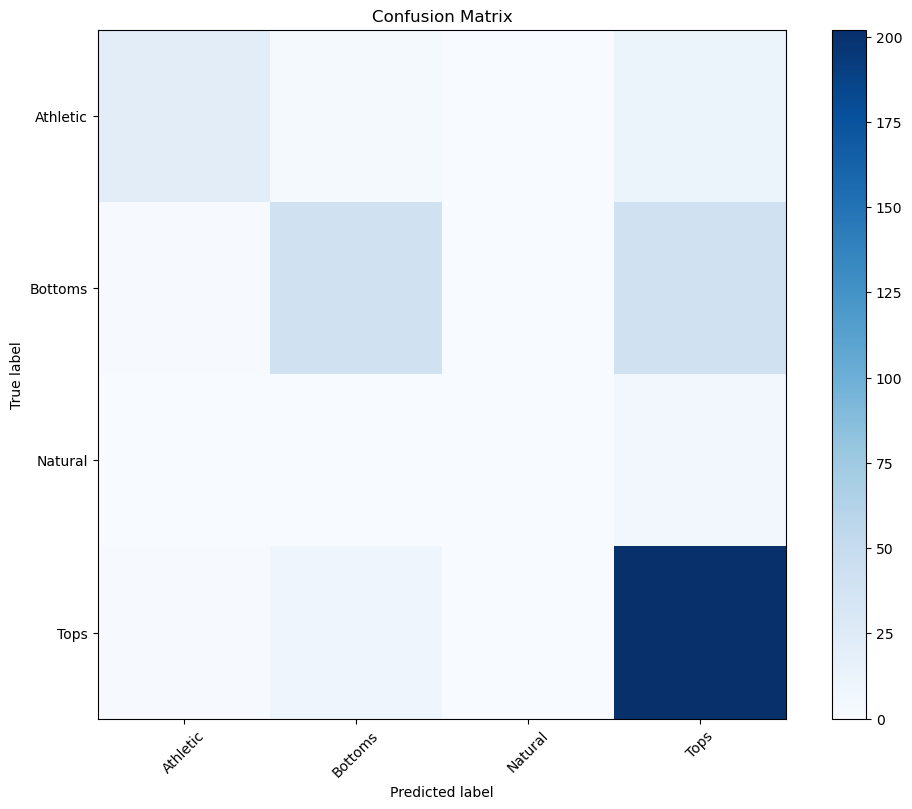

In [39]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(unique_labels))
plt.xticks(tick_marks, unique_labels, rotation=45)
plt.yticks(tick_marks, unique_labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

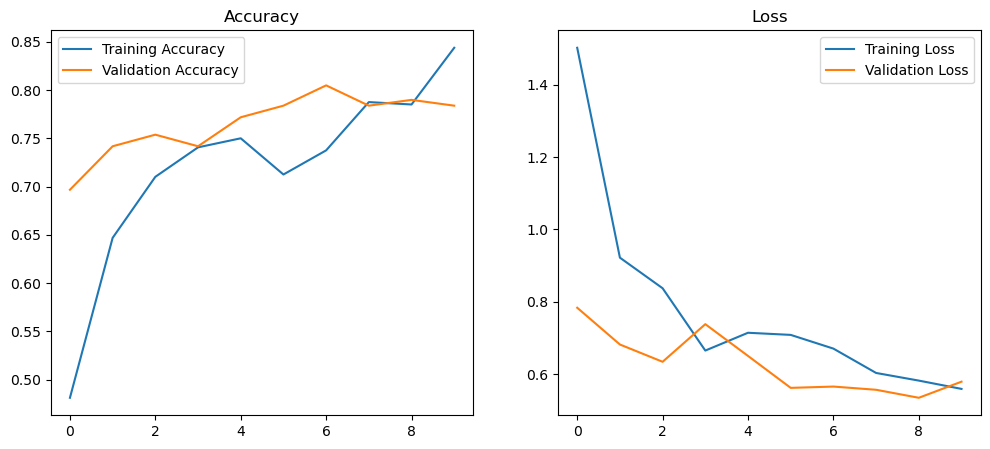

In [40]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [41]:
model.save("clothesclassificationmodel.h5")
